## 0. Import Libraries

In [237]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from ftfy import fix_text
from num2words import num2words

import textstat

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [238]:
# Load the data for original fake job posting
dataset_path = "../Raw Data Files/fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)

df_fakejobs = pd.read_csv('../Scraping/Fake Data/cf_fakejobs.csv')
df_cleaned_nonfraud = pd.read_csv('../Scraping/CareersFuture/cleaned_data_nonfraud.csv')

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 1. CareersFuture and Original Data Job Posting

In [239]:
df_fakejobs['fraudulent'] = 1
df_cleaned_nonfraud['fraudulent'] = 0

dataset_cf = pd.concat([df_fakejobs, df_cleaned_nonfraud], ignore_index=True)

dataset_cf.head()


,job_post_id,title,address,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,min_experience,company,industry,salary_type,fraudulent
0,MCF-2023-03021,Senior Project Manager,"50 Raffles Place, #15-01, Singapore Land Tower...",Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,8,Global Solutions Ltd.,Project Management,Monthly,1
1,MCF-2023-03022,Legal Counsel,"6 Battery Road, #20-01, Singapore 049909",Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,4,LegalEase Partners,Legal Services,Monthly,1
2,MCF-2023-03023,Data Analyst (Contract),"3 Church Street, Samsung Hub, Singapore 049483",Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,5,TechData Analytics,Data Analytics,Monthly,1
3,MCF-2023-03024,Marketing Director,"1 Raffles Quay, North Tower, Singapore 048583",Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,2,MaxiMedia Group,Marketing,Monthly,1
4,MCF-2023-03025,UX/UI Designer,"9 Temasek Boulevard, #04-02, Suntec Tower Two,...",Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,0,DesignMasters Co.,Design,Monthly,1


In [240]:
#Country

dataset_cf['location'] = np.where(dataset_cf['address'].notna(), 'SG', '')

dataset_cf.rename(columns={'requirement': 'requirements', 'job_post_id': 'job_id'}, inplace=True)

del dataset_cf['address'], dataset_cf['company'], dataset_cf['industry'], dataset_cf['salary_type'], dataset_cf['min_experience']

dataset_cf.head()


,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,location
0,MCF-2023-03021,Senior Project Manager,Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,1,SG
1,MCF-2023-03022,Legal Counsel,Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,1,SG
2,MCF-2023-03023,Data Analyst (Contract),Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,1,SG
3,MCF-2023-03024,Marketing Director,Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,1,SG
4,MCF-2023-03025,UX/UI Designer,Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,1,SG


In [241]:
dataset = pd.concat([dataset, dataset_cf], ignore_index=True)

dataset.head()
dataset.shape[1]

18

## 2. Basic Understanding of the Data

In [242]:
print(dataset.shape)
dataset.info()

(25996, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25996 entries, 0 to 25995
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               25996 non-null  object
 1   title                25996 non-null  object
 2   location             25650 non-null  object
 3   department           14449 non-null  object
 4   salary_range         10979 non-null  object
 5   company_profile      22688 non-null  object
 6   description          25742 non-null  object
 7   requirements         17066 non-null  object
 8   benefits             11359 non-null  object
 9   telecommuting        25996 non-null  int64 
 10  has_company_logo     25996 non-null  int64 
 11  has_questions        25996 non-null  int64 
 12  employment_type      22525 non-null  object
 13  required_experience  18912 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [243]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15017
company_profile         3308
description              254
requirements            8930
benefits               14637
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7084
required_education     16221
industry               13019
function               14571
fraudulent                 0
dtype: int64

<Axes: >

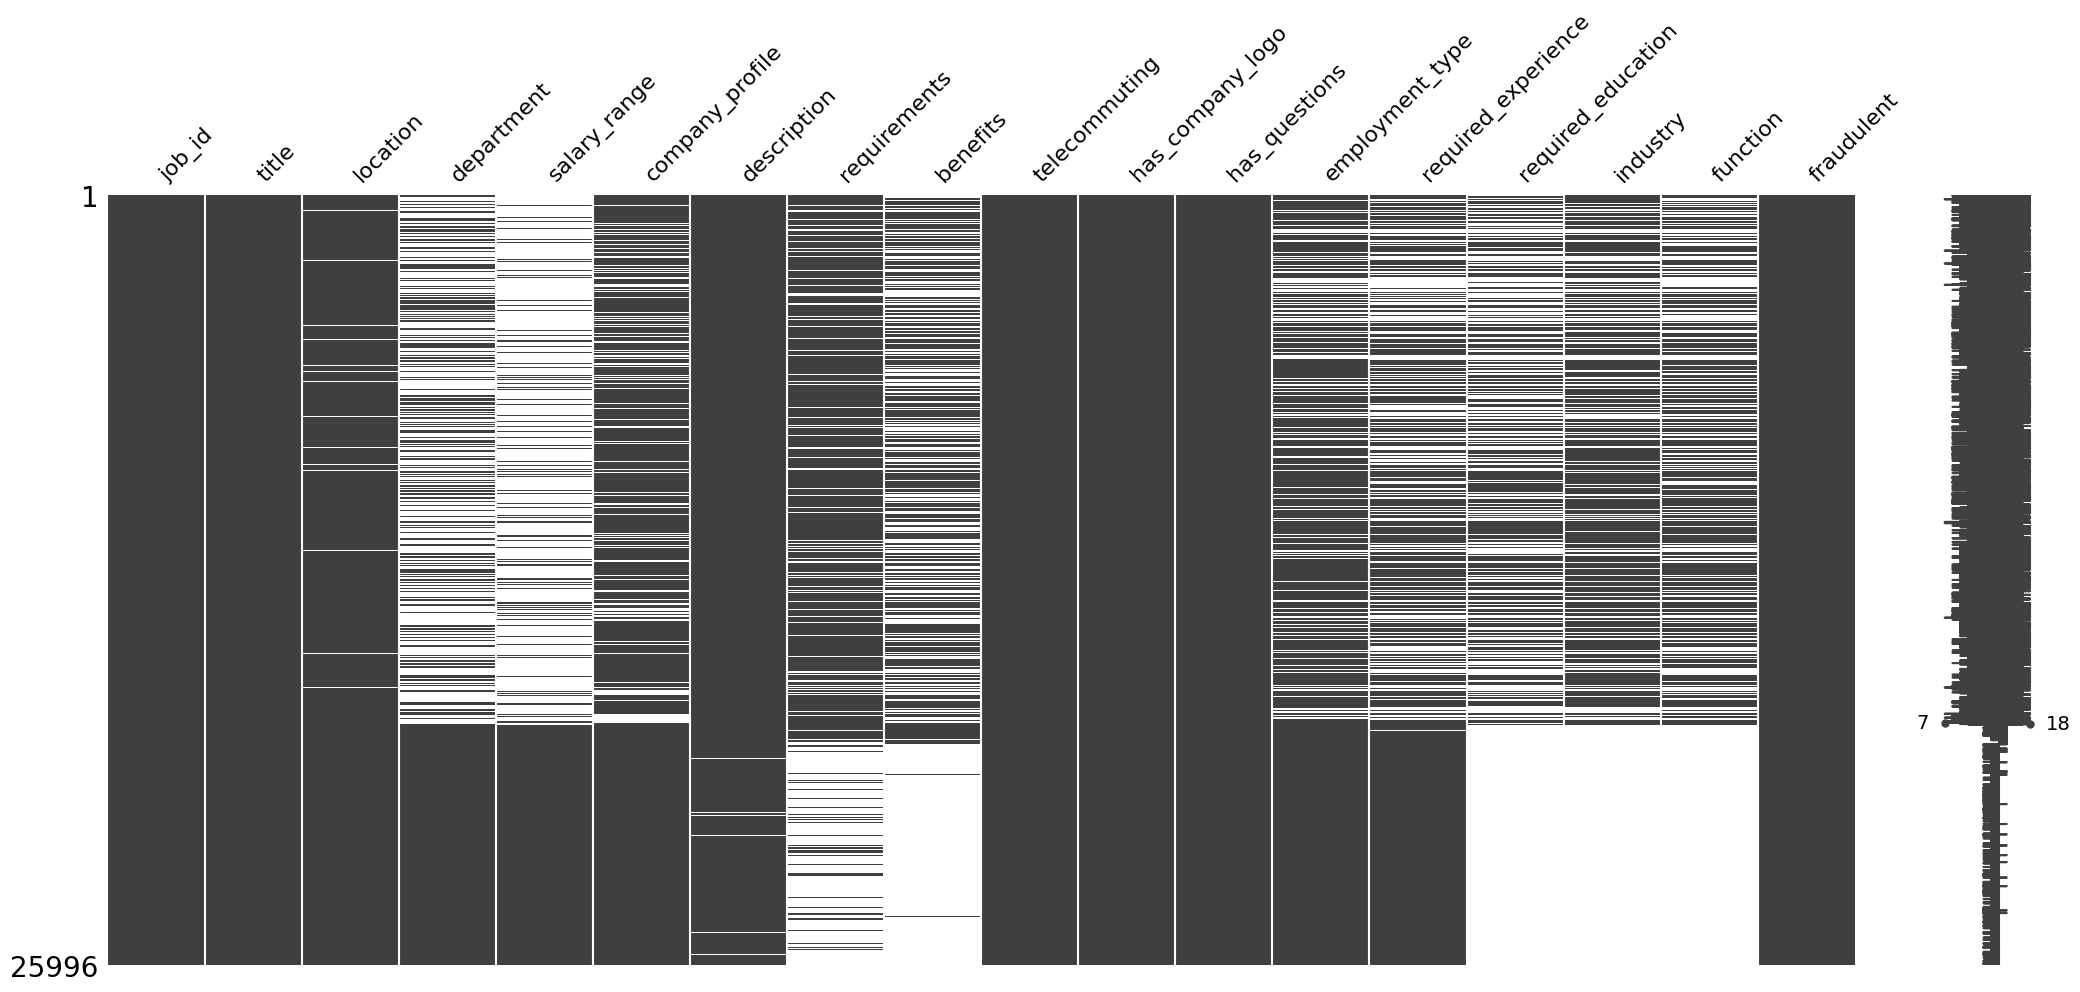

In [244]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This is followed by required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not.

## 2. Feature Engineering

### 2.1 Salary Range 

We will drop the Salary Range as there are too many missing values. 

In [245]:
del dataset['salary_range']

### 2.2 Country Identification

In [246]:
# Keep only country
dataset['location_country'] = dataset['location'].str.split(',').str[0].str.strip()
columns = ['location_country']
dataset[columns] = dataset[columns].applymap(lambda x: x if x else np.NaN)
dataset.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [247]:
# location_country
dataset['location_country'].value_counts(dropna=False).head(10)

location_country
US     10656
SG      5230
NaN     3312
GB      2384
GR       940
CA       457
DE       383
NZ       333
IN       276
AU       214
Name: count, dtype: int64

### 2.3 Title, Company Profile, Description, Requirements, Benefits

We are combining the 5 columns into a column called full_text.

In [248]:
dataset['title_contain_urgent'] = dataset['title'].apply(lambda x: 1 if 'urgent' in x.lower() else 0)
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)

# combine text, add in 'title'
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset['full_text'] = dataset['title'] + ' ' + dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']

dataset.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...


In [249]:
# Calculate readability scores for the "category" column
dataset['ft_flesch_score'] = dataset['full_text'].apply(textstat.flesch_reading_ease) #low score = very confusing
dataset['ft_fk_grade_level'] = dataset['full_text'].apply(textstat.flesch_kincaid_grade)

#flesch score binning
def map_to_flesch_score(score):
    if score >= 90:
        return "Very Easy"
    elif 80 <= score <= 89:
        return "Easy"
    elif 70 <= score <= 79:
        return "Fairly Easy"
    elif 60 <= score <= 69:
        return "Standard"
    elif 50 <= score <= 59:
        return "Fairly Difficult"
    elif 30 <= score <= 49:
        return "Difficult"
    else:
        return "Very Difficult"
    
#grade level binning
def map_to_fk_grade_level(score):
    if score >= 18:
        return "Advanced"
    elif 12 <= score <= 17:
        return "Skilled"
    elif 6 <= score <= 11:
        return "Average"
    elif 0 <= score <= 5:
        return "Basic"
    else:
        return "Beginner"
    
dataset['flesch_score_bin_ft'] = dataset['ft_flesch_score'].apply(map_to_flesch_score)

dataset['fk_grade_level_bin_ft'] = dataset['ft_fk_grade_level'].apply(map_to_fk_grade_level)

del dataset['ft_flesch_score']
del dataset['ft_fk_grade_level']

dataset.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",Very Difficult,Advanced
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,Difficult,Skilled
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,Very Difficult,Skilled
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,Very Difficult,Advanced
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,Very Difficult,Advanced


## 3. Data Cleaning

In [250]:
# drop useless columns
drop_cols = ['job_id','location','company_profile','description','requirements','benefits']
dataset = dataset.drop(drop_cols,axis=1)
dataset.head()

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft
0,Marketing Intern,Marketing,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",Very Difficult,Advanced
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,Difficult,Skilled
2,Commissioning Machinery Assistant (CMA),NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,Very Difficult,Skilled
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,Very Difficult,Advanced
4,Bill Review Manager,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,Very Difficult,Advanced


### 4.1 Handle Missing Values

Columns with Missing Values:
- salary_range           15012
- location                 346
- company_profile         3308
description                1
requirements            2695
benefits                7210
- industry                4903
department             11547
function                6455
- employment_type         3471
required_experience     7050
required_education      8105

#### 4.1.1 location

In [251]:
dataset['location_country'] = dataset['location_country'].fillna('unspecified')

#### 4.1.2 Identifying high salary

In [252]:
## salary_range: refer to the above part
## salary_group: 'unspecified'?

## high_salary is a binary indicator if the salary is in high or extremely high range

def check_high_salary(text):
    lower_text = text.lower()
    if 'high paid' in lower_text or 'high pay' in lower_text or 'highly paid' in lower_text or 'high-paid' in lower_text:
        return 1
    else:
        return 0

# Apply the function to create the 'high_salary' column
dataset['high_salary'] = dataset['full_text'].apply(check_high_salary)

dataset['high_salary'].max()

1

#### 4.1.3 department & industry & function

In [253]:
# fill in with the help of key words from 'title'
str_list = ['Engineer','Account','Accountant','Accounting','Developer','Sales','Marketing','Beauty','Service','Customer','Consumer',
'Customer','Writer','Pet','Architect', 'Dog', 'Game', 'Mobile', 'Design', 'Financial','Programmer']

for strs in str_list:
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['department'].isna()),'department'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['department'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['industry'].isna()),'industry'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['industry'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['function'].isna()),'function'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['function'].mode()[0]

dataset[['department','industry','function']] = dataset[['department','industry','function']].fillna('unspecified')

# dataset['depa_indus_func'] = dataset['department'] + ' ' + dataset['industry'] + ' ' + dataset['function']
# then clean, drop extra words

In [254]:
dataset[['department']] = dataset[['department']].fillna('')
dataset[['industry']] = dataset[['industry']].fillna('')
dataset[['function']] = dataset[['function']].fillna('')
dataset['category'] = dataset['department'] + ' ' + dataset['industry'] + ' ' + dataset['function']

#merge already and discard duplicated words
def remove_duplicates(text):
    words = text.split()
    unique_words = list(dict.fromkeys(words))
    return " ".join(unique_words)

dataset['category'] = dataset['category'].apply(remove_duplicates)

dataset.head()

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category
0,Marketing Intern,Marketing,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",Very Difficult,Advanced,0,Marketing and Advertising
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,Difficult,Skilled,0,Success Marketing and Advertising Customer Ser...
2,Commissioning Machinery Assistant (CMA),unspecified,0,1,0,NaN,NaN,NaN,unspecified,unspecified,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,Very Difficult,Skilled,0,unspecified
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,Very Difficult,Advanced,0,Sales Computer Software
4,Bill Review Manager,unspecified,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,Very Difficult,Advanced,0,unspecified Hospital & Health Care Provider


In [255]:
# full_text
fraud_cat = dataset[dataset.fraudulent == 1].category
nonfraud_cat = dataset[dataset.fraudulent == 0].category

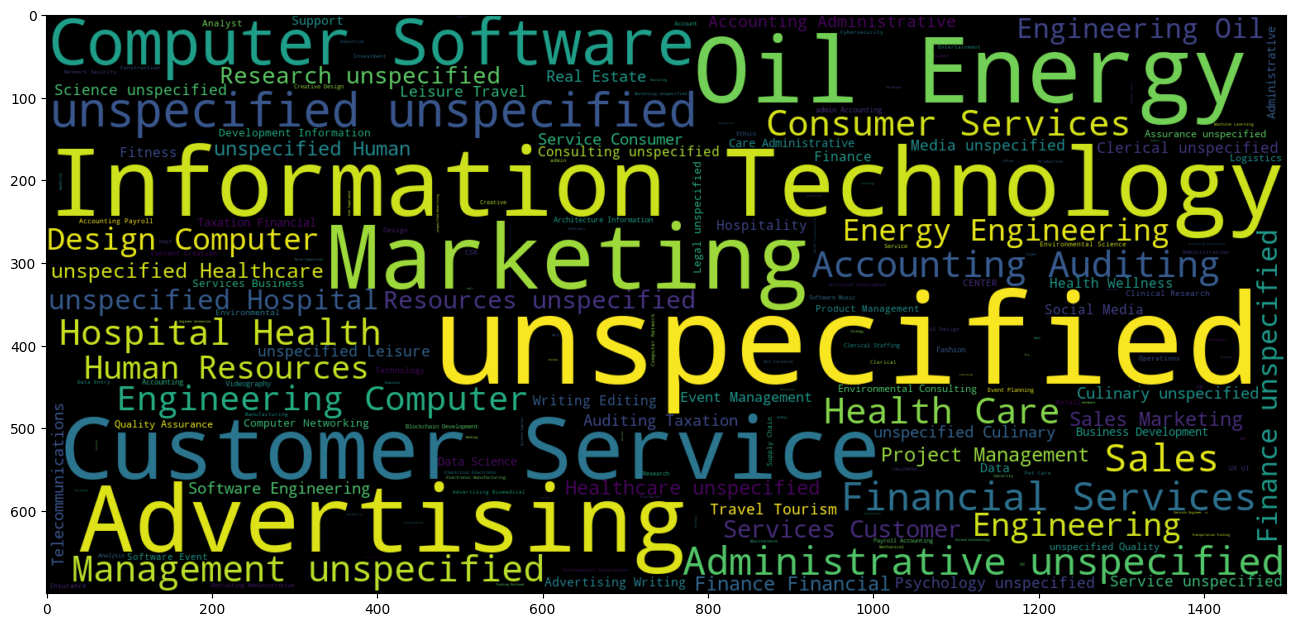

In [256]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

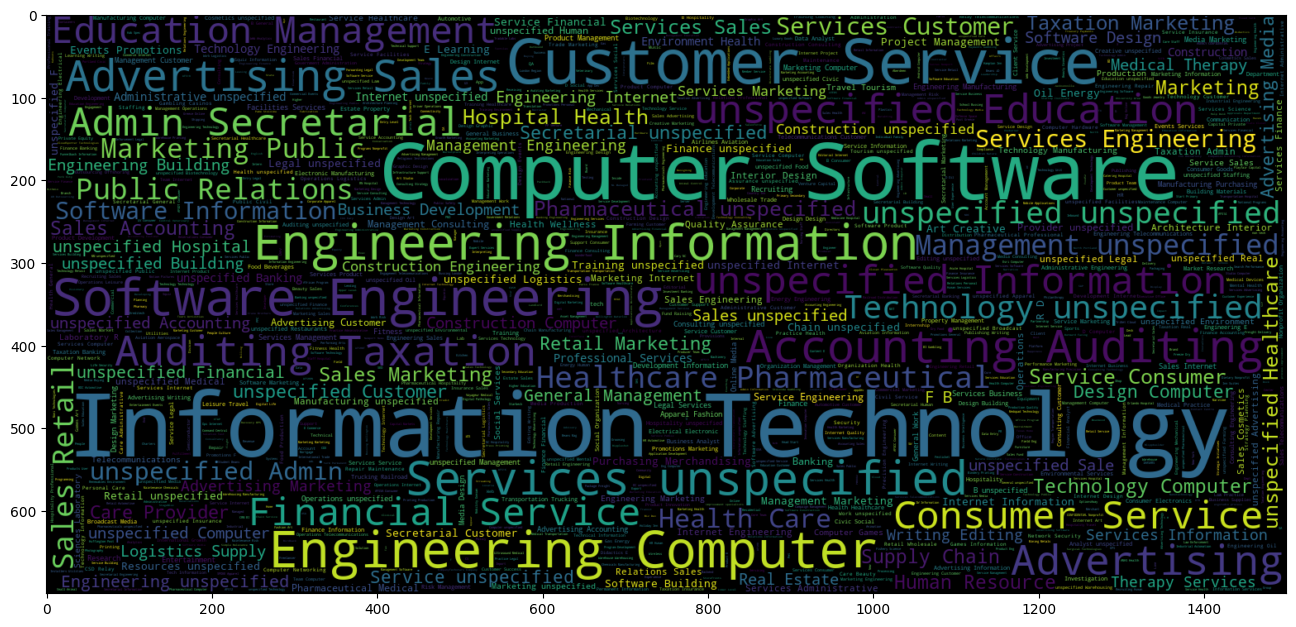

In [257]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

In [258]:
#textstat - check text complexity (python package) https://pypi.org/project/textstat/

# Calculate readability scores for the "category" column
dataset['cat_flesch_score'] = dataset['category'].apply(textstat.flesch_reading_ease) #low score = very confusing
dataset['cat_fk_grade_level'] = dataset['category'].apply(textstat.flesch_kincaid_grade)
    
dataset['flesch_score_cat'] = dataset['cat_flesch_score'].apply(map_to_flesch_score)

dataset['fk_grade_level_cat'] = dataset['cat_fk_grade_level'].apply(map_to_fk_grade_level)

#Once done binning, drop the col
del dataset['cat_fk_grade_level']
del dataset['cat_flesch_score']

dataset.head()


,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category,flesch_score_cat,fk_grade_level_cat
0,Marketing Intern,Marketing,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",Very Difficult,Advanced,0,Marketing and Advertising,Very Difficult,Beginner
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,Difficult,Skilled,0,Success Marketing and Advertising Customer Ser...,Very Difficult,Skilled
2,Commissioning Machinery Assistant (CMA),unspecified,0,1,0,NaN,NaN,NaN,unspecified,unspecified,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,Very Difficult,Skilled,0,unspecified,Very Difficult,Advanced
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,Very Difficult,Advanced,0,Sales Computer Software,Difficult,Average
4,Bill Review Manager,unspecified,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,Very Difficult,Advanced,0,unspecified Hospital & Health Care Provider,Difficult,Average


#### 4.1.4 Employment_type, Required_experience, Required_education

In [259]:
## error in this code 

## first fill in employment_type using 'title', but if has no key words, fill in with 'unspecified'
# dataset[['employment_type']] = dataset[['employment_type']].fillna('')

## then, fill in experience & education with the mode in each sub-group of employment_type
# Other, Full-time, unspecified, Part-time, Contract, Temporary
#employ_type_list = ['Full-time','Other','Part-time','Contract','Temporary','unspecified']
#for employ_type in employ_type_list:
#    dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_experience'].isna()),'required_experience'] = dataset[dataset['employment_type']==employ_type]['required_experience'].mode()[0]
#    dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_education'].isna()),'required_education'] = dataset[dataset['employment_type']==employ_type]['required_education'].mode()[0]

In [260]:
dataset.isna().sum()

title                        0
department                   0
telecommuting                0
has_company_logo             0
has_questions                0
employment_type           3471
required_experience       7084
required_education       16221
industry                     0
function                     0
fraudulent                   0
location_country             0
title_contain_urgent         0
have_company_profile         0
have_description             0
have_requirements            0
have_benefits                0
full_text                    0
flesch_score_bin_ft          0
fk_grade_level_bin_ft        0
high_salary                  0
category                     0
flesch_score_cat             0
fk_grade_level_cat           0
dtype: int64

### 4.2 Drop Columns with Low Variance

In [261]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           0.050956
has_company_logo        0.126009
has_questions           0.232130
fraudulent              0.055461
title_contain_urgent    0.002953
have_company_profile    0.111062
have_description        0.009676
have_requirements       0.225521
have_benefits           0.246034
high_salary             0.000461
dtype: float64


In [262]:
del dataset['have_description']

### 4.3 Clean text data

In [263]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs

def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc.split(' ')])
  return doc

# to clean data
def normalise_text(text,remove_stop_words=True):
    text = fix_text(text)
    text = text.lower() # lowercase
    text = text.replace("'","").replace("’","") # remove apostrophes ("can't">"cant")
    text = re.sub('#\S+#', " ", text) # removes #URL_...# #PHONE_...# #EMAIL_...# #*_...#
    text = re.sub('\xa0', " ", text) # remove \xa0
    text = re.sub('<.*?>'," ",text) # remove <> tags
    text = re.sub('#\S+', " ", text) # replaces hashtags
    text = re.sub('@\S+', " ", text)  # remove mentions
    text = re.sub("http\S+", " ", text) # remove URL addresses starting with http
    text = re.sub('www\S+', " ", text) # remove URL addresses starting with www
    text = re.sub('\d+', lambda x: ' '+num2words(x.group(), to='cardinal')+' ', text) # convert numbers to words ('food52'>'food fifty-two ')
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    text = re.sub('\s{2,}', " ", text).strip() # replace more than or equal to two white spaces into one white space
    if remove_stop_words:
      stop_words = set(nltk.corpus.stopwords.words('english'))
      text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # if stem_words:
    # stemmer = PorterStemmer()
    # text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [264]:
#error in code

#text_cols = ['full_text', 'category', 'employment_type', 'required_experience', 'required_education']
#for col in text_cols:
#    dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))
# dataset.head()



In [265]:
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))
dataset.head()

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category,flesch_score_cat,fk_grade_level_cat,text_len
0,Marketing Intern,Marketing,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,US,0,1,1,0,marketing intern food fifty two weve created g...,Very Difficult,Advanced,0,Marketing and Advertising,Very Difficult,Beginner,267
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,customer service cloud video production ninety...,Difficult,Skilled,0,Success Marketing and Advertising Customer Ser...,Very Difficult,Skilled,567
2,Commissioning Machinery Assistant (CMA),unspecified,0,1,0,NaN,NaN,NaN,unspecified,unspecified,0,US,0,1,1,0,commissioning machinery assistant cma valor se...,Very Difficult,Skilled,0,unspecified,Very Difficult,Advanced,235
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,account executive washington dc passion improv...,Very Difficult,Advanced,0,Sales Computer Software,Difficult,Average,497
4,Bill Review Manager,unspecified,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,bill review manager spotsource solutions llc g...,Very Difficult,Advanced,0,unspecified Hospital & Health Care Provider,Difficult,Average,370


In [266]:
#save to an output file

dataset.to_csv('../Raw Data Files/final_job_posting.csv', index=False)

## 4. Preprocessing

- frequency encoding: title,industry,department,function,salary_range
- embeddings: full_text(company_profile,description,requirements,benefits)
- one-hot encoding: others
- location: split(',') then frequency encoding

In [267]:
df = dataset.copy()

In [268]:
# train test split
from sklearn.model_selection import train_test_split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

### 4.1 Encoding

In [269]:
# ordinal encoding for salary_group (no more salary_group)

#from sklearn.preprocessing import OrdinalEncoder

# ordinal = OrdinalEncoder(
#     categories = [['Extremly Low','Low','Sligtly Low','Slightly High','High','Extremly High' ]],  # order of the categorical values
#     handle_unknown = 'use_encoded_value',  #  what to do for unknown values not in the categories list
#     unknown_value = -1 # what to replace these unknown values with
# )

# ordinal.fit_transform(X_train[['salary_group']])

KeyError: "None of [Index(['salary_group'], dtype='object')] are in the [columns]"

In [ ]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(
    categories = [
            ['Full-time', 'Contract', 'Part-time','Temporary','Other','unavailable'], # employment_type
            ['unavailable', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive'], # required_experience
            ['unavailable',"Bachelor's Degree",'High School or equivalent','Unspecified',"Master's Degree",'Associate Degree','Certification','Some College Coursework Completed','Vocational','Professional','Doctorate','Some High School Coursework','Vocational - Degree','Vocational - HS Diploma','Vocational - Other','None','Vocational - HS Certificate','Vocational - Bachelor','Vocational - Master'], # required_education
            ['Information Technology and Services', 'Computer Software','Internet','Marketing and Advertising','Education Management','Financial Services','Hospital & Health Care','Consumer Services','Telecommunications','Oil & Energy','Retail','Real Estate','Accounting','Construction'], # Industry
            ['unavailable','Information Technology','Sales','Engineering','Customer Service','Marketing','Administrative','Design','Health Care Provider','Other','Education','Management','Business Development','Accounting/Auditing','Human Resources','Project Management','Finance','Consulting','Writing/Editing','Art/Creative','Production','Quality Assurance','Data Analyst','Research','Manufacturing','Advertising','Public Relations','Legal','Distribution','Product Management','Strategy/Planning','Purchasing','General Business','Science','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Information Technology','Facilities','QA','Skilled Labor','Business Development','Research Development','Science','Professional Services','Design','Product Management','Strategy/Planning','Purchasing','General Business','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Facilities','QA','Skilled Labor','Research Development','Professional Services','Logistics','Nonprofit','Operations Management','Nurse','Pharmaceutical'], # function
            ['US','GB','GR','CA','DE'] # location_country
     ],
     handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

onehot.fit_transform(X_train[[ 'employment_type', 'required_experience','required_education','industry','function','location_country']])

In [ ]:
pd.DataFrame.sparse.from_spmatrix(
    data = onehot.fit_transform(X_train[['employment_type', 'required_experience','required_education','industry','function','location_country']]),  # <- sparse matrix
    columns = onehot.get_feature_names_out(),                        # <- encoded features
    index = X_train.index
)

In [ ]:
df.columns

In [ ]:
# Combine them!

numerical_columns = ['telecommuting', 'has_company_logo','has_questions','have_company_profile', 'have_requirements', 'have_benefits','have_department','text_len','company_profile_isna' ]  # numerical columns
ordinal_columns = ['salary_group']        # categorical columns for ordinal encoding
onehot_columns = ['employment_type', 'required_experience','required_education','industry','function','location_country']                   # categorical columns for onehot encoding

from sklearn.compose import ColumnTransformer
encoder = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns)                 # <- apply onehot encoder to the onehot_columns
])

encoder

### 4.2 Get embeddings

In [ ]:
## pre trained
## tokenized, embedding layer

#### 4.2.2 Pre-trained RoBERTa

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
# in colab, select "Change runtime type," and choose "GPU" as the hardware accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

In [ ]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
model = model.to(device)

In [ ]:
# ~10 mins
# if don't use GPU, much slower!!
feature_list = []

with torch.no_grad():
    i=0
    for batch_idx in range(0,len(dataset),20):
      batch = dataset['full_text'][batch_idx:batch_idx+20]
      tokenized = tokenizer.batch_encode_plus(list(batch), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True)
      #check 20 sample each time
      input_ids = torch.tensor(tokenized['input_ids']).to(device)
      used_attention_mask = torch.tensor(tokenized['attention_mask']).to(device)
      last_hidden_states = model(input_ids, attention_mask=used_attention_mask)
      #Get the embeddings for the [CLS] tag (position is 0)
      features = last_hidden_states[0][:,0,:].cpu().numpy()
      feature_list.append(features)
      i = i+1
      if i % 100 == 0:
        print(i*20)

In [ ]:
features = np.vstack(feature_list)
features.shape

In [ ]:
# save features